#### Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import time
import signal
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
workspace_dir = Path.cwd().parent

In [19]:
def calc_rmse(x, y, x_gt, y_gt, average=True):
    if average:
        return np.sqrt(np.mean((x - x_gt)**2 + (y - y_gt)**2))
    else:
        return np.sqrt((x - x_gt)**2 + (y - y_gt)**2)

# assumption: convergence speed means first timestep where the position error stays below a threshold
def calc_convergence(rmse_over_time, est_t, threshold, req_time):
    num_logs = len(rmse_over_time)

    for i in range(num_logs):
        if (rmse_over_time[i] < threshold):
            curr_time = est_t[i]
            stays_below = True

            j = i
            while (j < num_logs) and ((est_t[j] - curr_time) < req_time):
                if (rmse_over_time[j] >= threshold):
                    stays_below = False
                    break
                j += 1

            if stays_below and j < num_logs and (est_t[j] - curr_time) >= req_time:
                return float(curr_time)

    return -1.0

def calc_stability(rmse_over_time):
    return np.std(rmse_over_time)

def build_project(cmd_output=False):
    build_cmd = f"cd {workspace_dir} && colcon build"

    build_proc = subprocess.run(
        build_cmd,
        shell=True,
        executable="/bin/bash",
        capture_output=True,
        text=True
    )

    if build_proc.returncode != 0:
        print("Error: Build failed!")
        print(build_proc.stdout)
        print(build_proc.stderr)
        return False

    if cmd_output: print(build_proc.stdout)

    return True

def launch_package(package_name, launch_file, param_list):
    source_cmd = "source ./install/setup.bash"

    param_str = ' '.join(param_list) if param_list else ''

    return f"cd {workspace_dir} && {source_cmd} && ros2 launch {package_name} {launch_file} {param_str}"

def start_process(cmd):
    return subprocess.Popen(
        cmd,
        shell=True,
        executable="/bin/bash",
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        text=True,
        start_new_session=True
    )

def stop_process(proc, sig=signal.SIGINT, wait_s=5):
    if proc.poll() is not None:
        return
    
    os.killpg(proc.pid, sig)

    try:
        proc.wait(timeout=wait_s)
    except subprocess.TimeoutExpired:
        os.killpg(proc.pid, signal.SIGKILL)

def run_simulation(duration=30,
                   num_particles=None,
                   measurement_noise_variance=None,
                   motion_noise=None
                   ):
    
    # build project with colcon
    if not build_project():
        return False

    # launch fake_robot
    fake_robot_params = []
    if num_particles is not None: fake_robot_params.append(f"num_particles:={num_particles}")
    if measurement_noise_variance is not None: fake_robot_params.append(f"measurement_noise_variance:={measurement_noise_variance}")
    if motion_noise is not None and len(motion_noise) == 4: 
        fake_robot_params.append(f"alpha1:={motion_noise[0]}")
        fake_robot_params.append(f"alpha2:={motion_noise[1]}")
        fake_robot_params.append(f"alpha3:={motion_noise[2]}")
        fake_robot_params.append(f"alpha4:={motion_noise[3]}")

    fake_robot_cmd = launch_package("fake_robot", "fake_robot.launch.py", fake_robot_params)

    processes = []
    try:
        print(20*"-", "Starting fake_robot node", 20*"-")
        fake_robot_proc = start_process(fake_robot_cmd)
        processes.append(fake_robot_proc)

        # run simulations for given time
        for i in range(duration):
            time.sleep(1)

        print(20*"-", "Simulation finished. Stopping processes", 20*"-")
    finally:
        # terminate processes
        for proc in reversed(processes):
            try:
                stop_process(proc)
            except:
                pass

    print(20*"-", "All processes terminated", 20*"-")
    print("Data collection finished. Ready for analysis.\n")

    return True

def run_experiment(duration=30,
                   num_particles=None,
                   measurement_noise_variance=None,
                   motion_noise=None
                   ):

    if not run_simulation(
        duration=duration,
        num_particles=num_particles,
        measurement_noise_variance=measurement_noise_variance,
        motion_noise=motion_noise
        ):

        print("Simulation failed")
        return False
    
    robot_gt = pd.read_csv(f"{workspace_dir}/robot_gt.csv")
    estimated_pos = pd.read_csv(f"{workspace_dir}/estimated_pos.csv")
    offset = len(robot_gt['x'].values) - min(len(estimated_pos['x'].values), len(robot_gt['x'].values))

    # rmse = calc_rmse(
    #     estimated_pos['x'].values,
    #     estimated_pos['y'].values,
    #     robot_gt['x'].values[offset:],
    #     robot_gt['y'].values[offset:]
    # )

    num_logs = len(estimated_pos['x'].values)
    
    est_t_ns = estimated_pos["timestamp"].to_numpy(dtype=np.int64)
    gt_t_ns  = robot_gt["timestamp"].to_numpy(dtype=np.int64)

    est_t = (est_t_ns - est_t_ns[0]) * 1e-9 
    gt_t  = (gt_t_ns  - gt_t_ns[0])  * 1e-9

    pos_error = []
    for i in range(num_logs):
        idx = np.argmin(np.abs(gt_t - est_t[i])) # frames matching

        rmse_t = calc_rmse(
            estimated_pos['x'].values[i],
            estimated_pos['y'].values[i],
            robot_gt['x'].values[idx],
            robot_gt['y'].values[idx],
            average=False
        )
        pos_error.append(rmse_t)
    
    errors = np.array(pos_error)
    rmse = np.sqrt(np.mean(errors**2))  
    convergence_time = calc_convergence(pos_error, est_t, threshold=0.8, req_time=2.0)
    stability = calc_stability(pos_error)
    
    return {
        'duration': duration,
        'measurement_noise_variance': measurement_noise_variance,
        'rmse': rmse,
        'pos_error':pos_error,
        'convergence_time': convergence_time,
        'sim_time':est_t,
        'stability': stability,
        'gt': robot_gt.copy(),
        'estimated_pos': estimated_pos.copy()
    }

#### Task B1: Particle Count Variation

In [32]:
num_particles = [100, 500, 1000, 2000, 5000]
results_b1 = []

for num in num_particles:
    results_b1.append(run_experiment(duration=35, num_particles=num))

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated ----------------

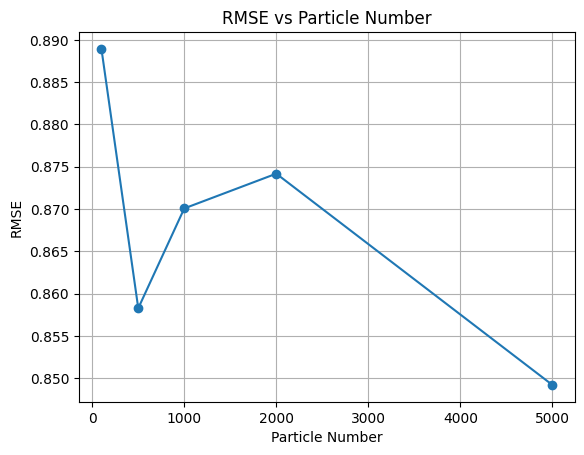

In [38]:
rmse = np.array([r["rmse"] for r in results_b1])

plt.plot(num_particles, rmse, marker="o")

plt.xlabel("Particle Number")
plt.ylabel("RMSE")
plt.title("RMSE vs Particle Number")
plt.grid(True)
plt.show()


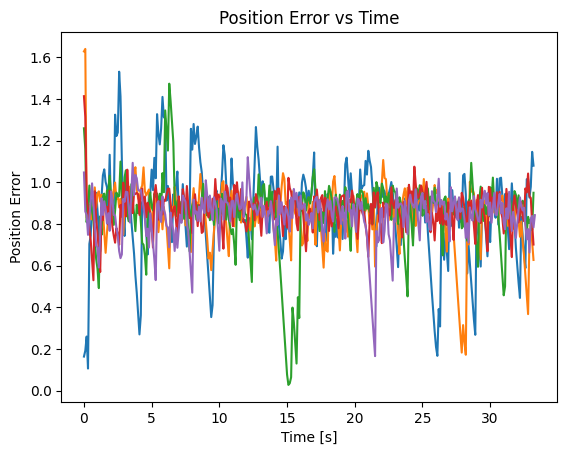

In [34]:
for i, r in enumerate(results_b1):
    pos_error = r["pos_error"]
    sim_time = r["sim_time"]

    plt.plot(sim_time, pos_error, label=f"run {i}")

plt.xlabel("Time [s]")
plt.ylabel("Position Error")
plt.title("Position Error vs Time")
plt.show()

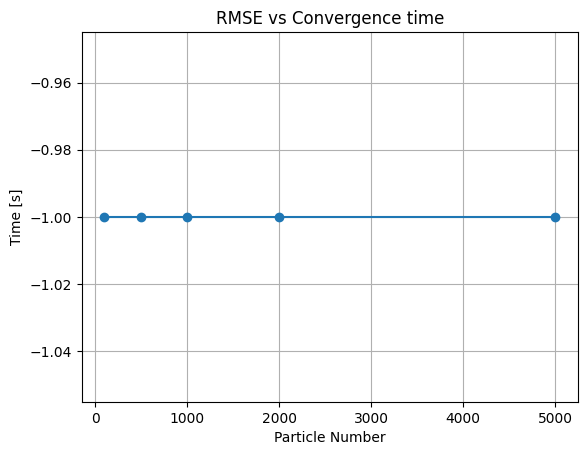

In [35]:
convergence_time = np.array([r["convergence_time"] for r in results_b1])

plt.plot(num_particles, convergence_time, marker="o")

plt.xlabel("Particle Number")
plt.ylabel("Time [s]")
plt.title("RMSE vs Convergence time")
plt.grid(True)
plt.show()


#### Task B2: Motion Noise Variation

In [26]:
motion_noise_values = [[0.01, 0.01, 0.02, 0.01],
                       [0.03, 0.03, 0.05, 0.03],
                       [0.05, 0.05, 0.1, 0.05],
                       [0.1, 0.1, 0.2, 0.1],
                       [0.2, 0.2, 0.4, 0.2]]
results_b2 = []

for motion_noise in motion_noise_values:
    results_b2.append(run_experiment(duration=35, motion_noise=motion_noise))

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated ----------------

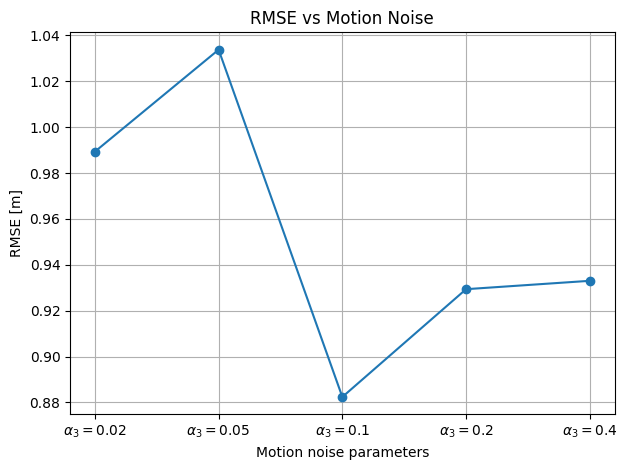

In [27]:
rmse = np.array([r["rmse"] for r in results_b2])
x = np.arange(len(rmse))

labels = [rf"$\alpha_3={noise[2]}$"for noise in motion_noise_values]

plt.plot(x, rmse, marker="o")
plt.xticks(x, labels)

plt.xlabel("Motion noise parameters")
plt.ylabel("RMSE [m]")
plt.title("RMSE vs Motion Noise")
plt.grid(True)
plt.tight_layout()
plt.show()


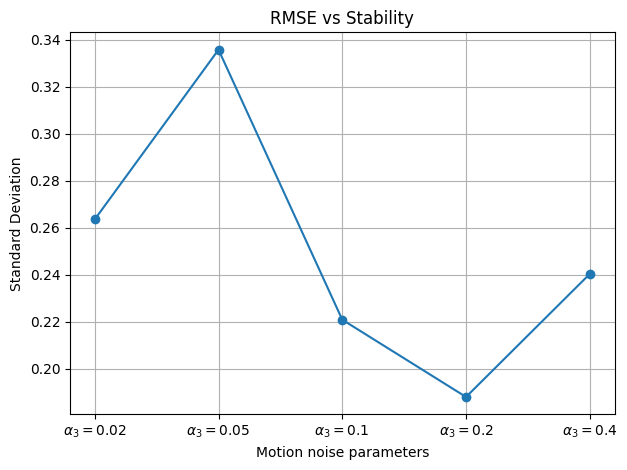

In [28]:
stability = np.array([r["stability"] for r in results_b2])
x = np.arange(len(stability))

labels = [rf"$\alpha_3={noise[2]}$"for noise in motion_noise_values]

plt.plot(x, stability, marker="o")
plt.xticks(x, labels)

plt.xlabel("Motion noise parameters")
plt.ylabel("Standard Deviation")
plt.title("RMSE vs Stability")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Task B3: Sensor Noise Variation

In [29]:
variance_sensor_noise = np.logspace(-4, 0, 5)
sigma_sensor_noise = [np.sqrt(x) for x in variance_sensor_noise]
results_b3 = []

for variance_noise in variance_sensor_noise:
    results_b3.append(run_experiment(duration=35, measurement_noise_variance=variance_noise))

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated --------------------
Data collection finished. Ready for analysis.

-------------------- Starting fake_robot node --------------------
-------------------- Simulation finished. Stopping processes --------------------
-------------------- All processes terminated ----------------

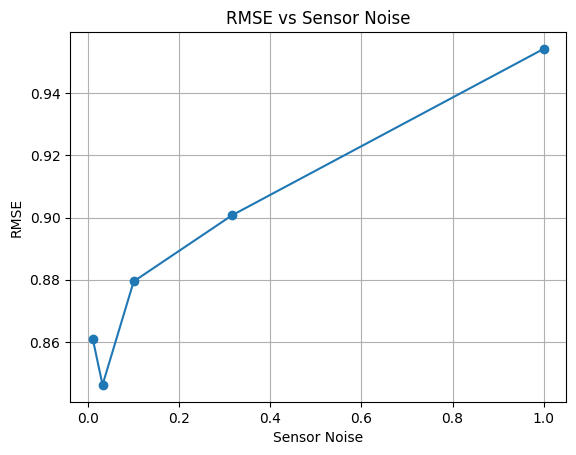

In [36]:
rmse = np.array([r["rmse"] for r in results_b3])

plt.plot(sigma_sensor_noise, rmse, marker="o")

plt.xlabel("Sensor Noise")
plt.ylabel("RMSE")
plt.title("RMSE vs Sensor Noise")
plt.grid(True)
plt.show()


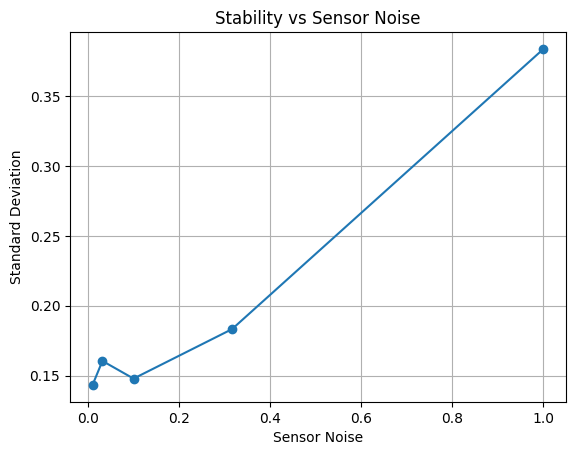

In [40]:
stability = np.array([r["stability"] for r in results_b3])

plt.plot(sigma_sensor_noise, stability, marker="o")

plt.xlabel("Sensor Noise")
plt.ylabel("Standard Deviation")
plt.title("Stability vs Sensor Noise")
plt.grid(True)
plt.show()
